In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [4]:
# Define the Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
# Initialize VAE model
latent_dim = 2  # Keeping it low for visualization
vae = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
loss_fn = nn.BCELoss(reduction='sum')

In [10]:
# Training loop
epochs = 10
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch, _ in train_loader:
        batch = batch.to(device)
        batch = batch.view(-1, 28 * 28)
        
        optimizer.zero_grad()
        recon, mu, logvar = vae(batch)
        
        # Compute loss
        recon_loss = loss_fn(recon, batch.view(-1, 28 * 28))
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_divergence

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}")

ValueError: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 1, 28, 28])) is deprecated. Please ensure they have the same size.

In [7]:
# Save trained model
torch.save(vae.state_dict(), "vae_fashion_mnist.pth")

In [8]:
# Generate samples from latent space
vae.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim).to(device)
    samples = vae.decode(z).cpu().numpy()

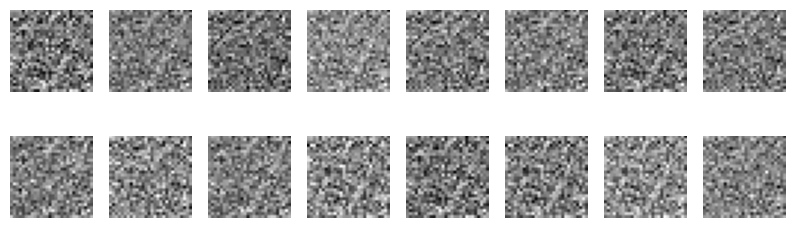

In [9]:
# Plot generated samples
fig, axes = plt.subplots(2, 8, figsize=(10, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.show()